## Introduction
This notebook tries to take in a sample dataset in notebook environment and run some tests to demo the verification of differential privacy algorithms. 

### Load the DP Verification Modules

In [1]:
import pandas as pd
import DPVerification as dp
import Aggregation as agg

### Load Data

In [2]:
dv = dp.DPVerification()
ag = agg.Aggregation(t=1)

Loaded 10000 records


### Test Parameters

In [3]:
repeatcount = 10000 # Repeating the aggregation these many times
# Using the auto method of np.histogram to decide bin size
# Maximum of the ‘sturges’ and ‘fd’ estimators. Provides good all around performance.
numbins = 0

## Exact Counts

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.0  Stdev fD1:  0.0  Mean fD2:  9999.0  Stdev fD2:  0.0

KS 2-sample Test Result:  Ks_2sampResult(statistic=1.0, pvalue=0.0) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  0.0 

DP Predicate Test: False 



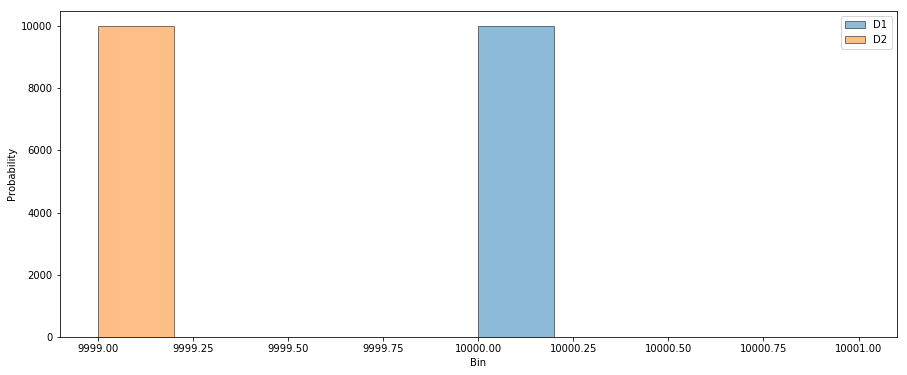

In [4]:
dp_exact, ks_exact, ws_exact = dv.aggtest(ag.exact_count, 'UserId', repeatcount, binsize = "unity", bound = False, exact = True)

If we do exact count repeatedly on a set D1 of 10K records and set D1 of 9,999 records (neighboring datasets), we shall get two histograms that are easily distinguishable from each other. So we can make out the extra record is in D1 vs D2. This is a trivial case of re-identification as it leads us to infer net new information about an individual record being part of D1 vs D2. 

#### Exact count fails the DP test

## Buggy Implementation of DP

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10004.967394600022  Stdev fD1:  2.9038229236537214  Mean fD2:  10003.979349547073  Stdev fD2:  2.901616465809466

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.10719999999999999, pvalue=1.6628946276700017e-50) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  3.0 

DP Predicate Test: False 



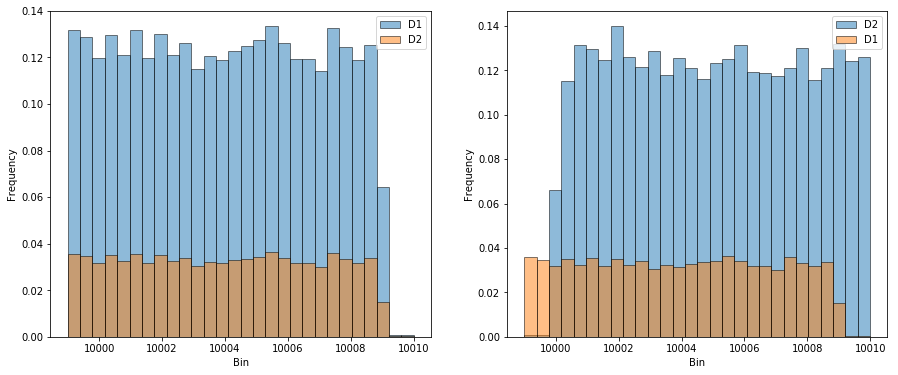

In [5]:
dp_buggy, ks_buggy, ws_buggy = dv.aggtest(ag.buggy_count, 'UserId', repeatcount, binsize="auto", debug=False,bound = True)

#### We can see that the histograms are not bounded. The test is able to uncover this implementation of DP noisy count is incorrect which is what we'd expect this test to uncover. 

## [DP Implementation as per MSR equations](https://www.yammer.com/microsoft.com/#/files/182490914816)

### COUNT Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.871385730805  Stdev fD1:  5.368257295621045  Mean fD2:  9998.97123189085  Stdev fD2:  5.387870582753535

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.06379999999999997, pvalue=3.651771010208054e-18) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  3.5681818181818192 

DP Predicate Test: True 



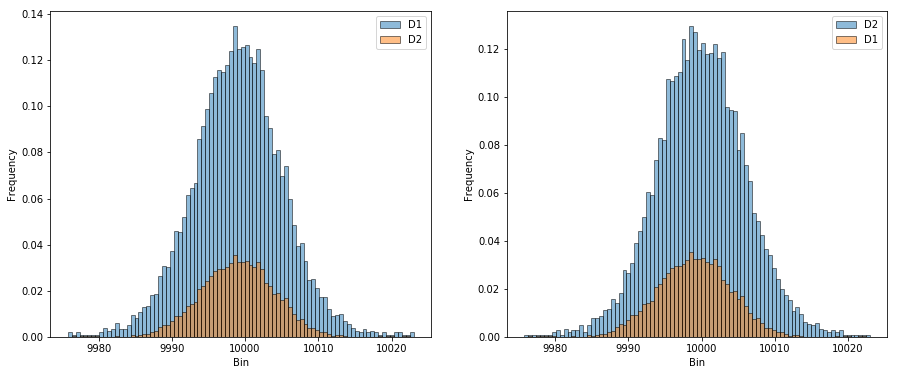

In [6]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', repeatcount, binsize="auto", debug = False)

#### Noisy COUNT aggregation passes the DP Predicate test

### SUM Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  19876.949562811995  Stdev fD1:  63.776429519417434  Mean fD2:  19875.616764257546  Stdev fD2:  64.04152171207586

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.014599999999999946, pvalue=0.23517556311047363) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  6.888888888888886 

DP Predicate Test: True 



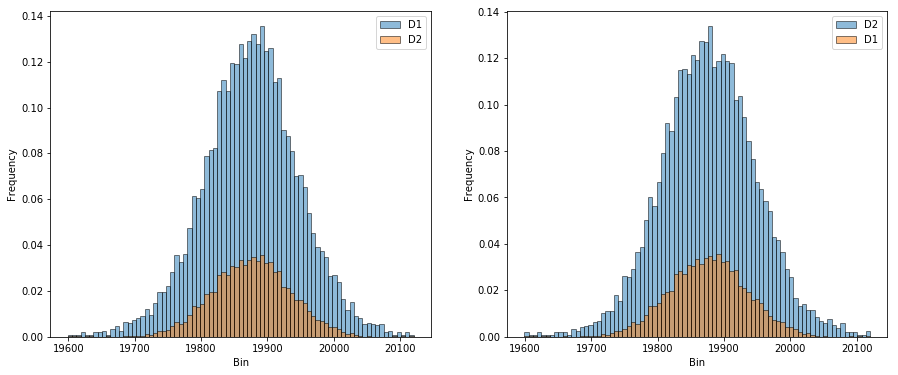

In [7]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', repeatcount, binsize="auto")

#### Noisy SUM aggregation passes the DP predicate test

### Mean Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  1.9877906581029212  Stdev fD1:  0.006446051565303903  Mean fD2:  1.9876765926572313  Stdev fD2:  0.006498294081635946

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.009800000000000031, pvalue=0.7209408433518331) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  9.387755102040817 

DP Predicate Test: True 



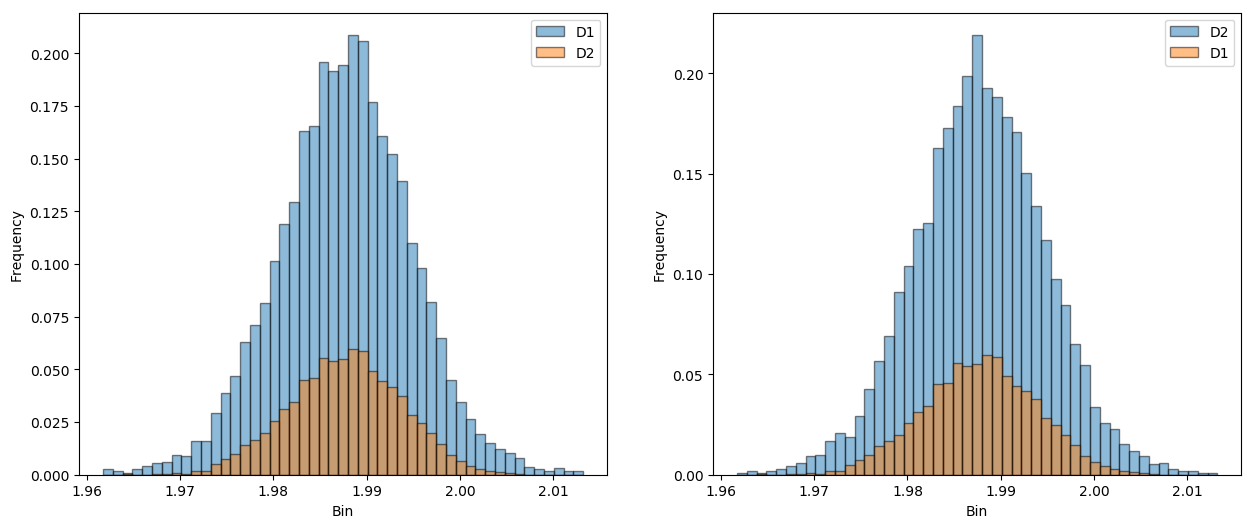

In [18]:
dp_mean, ks_mean, ws_mean = dv.aggtest(ag.dp_mean, 'Usage', repeatcount, numbins=50, debug=False)

#### Noisy mean passes the DP Predicate test

### Variance Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  1.9214863441107908  Stdev fD1:  0.09351969187972314  Mean fD2:  1.9207301039248574  Stdev fD2:  0.09290377895922441

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.016100000000000003, pvalue=0.14833515907692768) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  2.792452830188679 

DP Predicate Test: True 



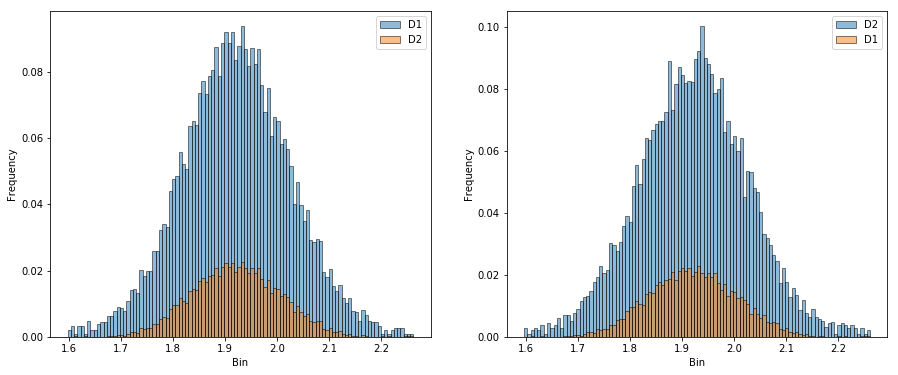

In [9]:
dp_var, ks_var, ws_var = dv.aggtest(ag.dp_var, 'Usage', repeatcount, binsize="auto", debug=False)

### Comparing fD1 and fD2 without bounding

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.985250988293  Stdev fD1:  5.408602544929336  Mean fD2:  9998.991442918297  Stdev fD2:  5.380040514324248

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.07689999999999997, pvalue=3.389791023627198e-26) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  5.999999999999998 

DP Predicate Test: True 



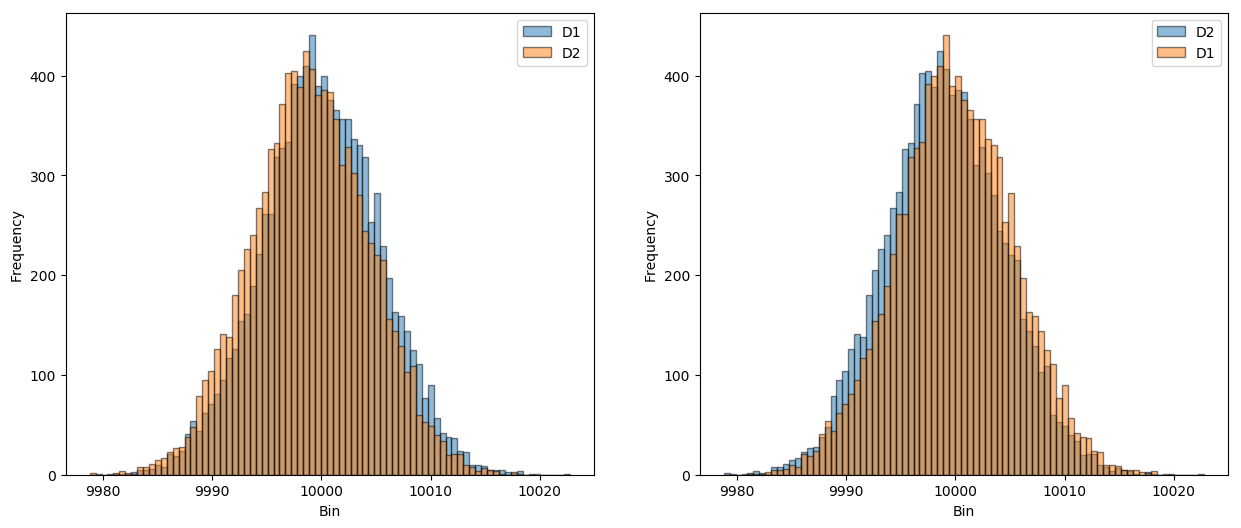

(True,
 Ks_2sampResult(statistic=0.07689999999999997, pvalue=3.389791023627198e-26),
 5.999999999999998)

In [15]:
dv.aggtest(ag.dp_count, 'UserId', repeatcount, numbins, debug = False, bound=False)

### Plotting KS Test Results by different aggregate functions

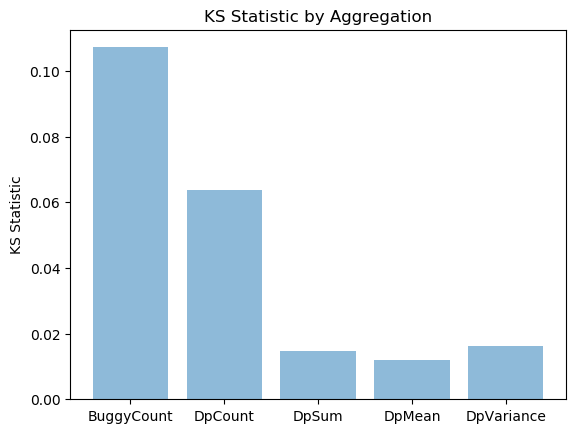

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('BuggyCount', 'DpCount', 'DpSum', 'DpMean', 'DpVariance')
y_pos = np.arange(len(objects))

ks_stat = [ks_buggy[0],
          ks_count[0],
          ks_sum[0],
          ks_mean[0],
          ks_var[0]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS Statistic')
plt.title('KS Statistic by Aggregation')

plt.show()

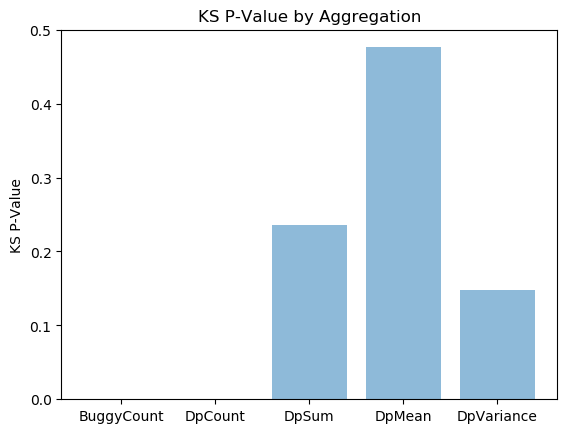

In [12]:
ks_stat = [ks_buggy[1],
          ks_count[1],
          ks_sum[1],
          ks_mean[1],
          ks_var[1]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS P-Value')
plt.title('KS P-Value by Aggregation')

plt.show()

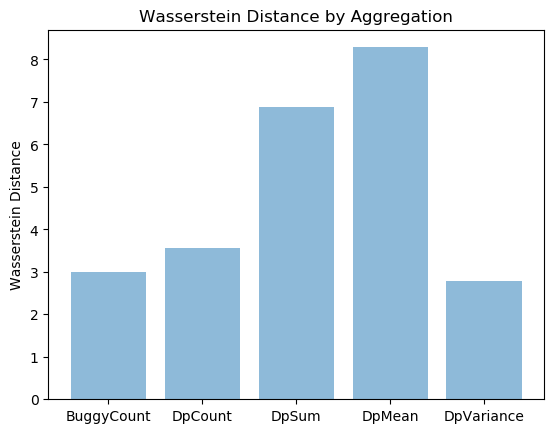

In [13]:
ws_stat = [ws_buggy,
          ws_count,
          ws_sum,
          ws_mean,
          ws_var]

plt.bar(y_pos, ws_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance by Aggregation')

plt.show()

### Time to run the DP Tests

In [24]:
import time
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', repeatcount, binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.061994989717  Stdev fD1:  5.3406190858518165  Mean fD2:  9998.953983915899  Stdev fD2:  5.3343540492016635

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.08799999999999997, pvalue=3.5771416486765323e-34) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  5.037037037037041 

DP Predicate Test: True 

--- 0.021004676818847656 seconds ---


In [25]:
import time
start_time = time.time()
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', repeatcount, binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  19878.514214622326  Stdev fD1:  63.56700599829805  Mean fD2:  19872.46052244049  Stdev fD2:  63.51058981375218

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.04289999999999994, pvalue=1.908653787734046e-08) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  4.415584415584416 

DP Predicate Test: True 

--- 0.01899862289428711 seconds ---


In [28]:
import time
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.buggy_count, 'UserId', repeatcount, binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10004.987707370694  Stdev fD1:  2.8819269833396355  Mean fD2:  10004.031210659097  Stdev fD2:  2.871282715936008

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.10610000000000008, pvalue=1.751282750254031e-49) 

Sum of frequencies in D1 Histogram:  10000
Sum of frequencies in D2 Histogram:  10000
Wasserstein Distance Test:  8.96551724137931 

DP Predicate Test: False 

--- 0.024997949600219727 seconds ---
